cuda


100%|██████████| 118/118 [00:17<00:00,  6.79it/s]


Epoch 0 | Loss: 0.0646190751280825
Checkpoint saved at data/FashionMNIST/checkpoint_epoch_0.pth


1000it [00:07, 132.77it/s]


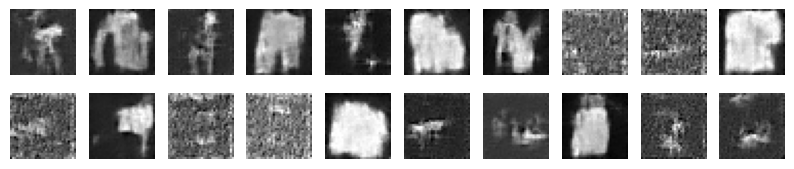

100%|██████████| 118/118 [00:17<00:00,  6.76it/s]


Epoch 1 | Loss: 0.027435639762651114
Checkpoint saved at data/FashionMNIST/checkpoint_epoch_1.pth


1000it [00:07, 133.05it/s]


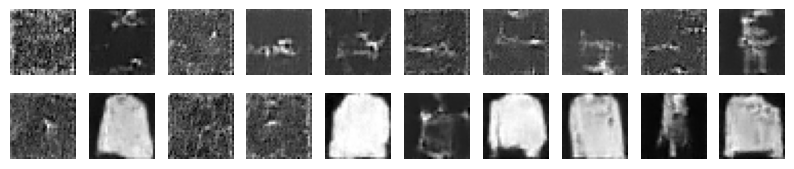

100%|██████████| 118/118 [00:17<00:00,  6.79it/s]


Epoch 2 | Loss: 0.023429448866301168
Checkpoint saved at data/FashionMNIST/checkpoint_epoch_2.pth


1000it [00:07, 131.62it/s]


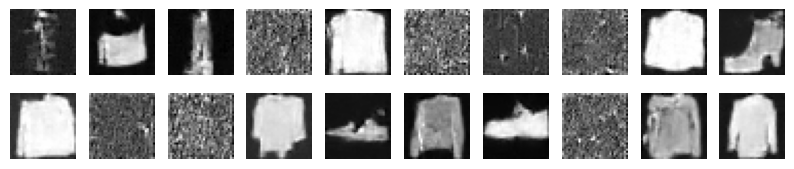

 72%|███████▏  | 85/118 [00:12<00:04,  6.76it/s]

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from diffusers import UNet2DModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Hyperparameters
img_size = 32
batch_size = 512
max_steps = 1000
lr = 1e-3
epochs = 1000

def prepare_dataset(batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    # FashionMNISTデータセットの読み込み
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=transform)

    # DataLoaderの作成
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for _ in range(rows):
        for _ in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
            plt.axis('off')
            i += 1
    plt.show()

def diffusion_process(scheduler, model):
    samples = torch.randn((20, 1, img_size, img_size), device=device)
    for _, t in tqdm(enumerate(scheduler.timesteps)):
        samples = scheduler.step(model(samples, t).sample, t, samples).prev_sample
    return samples

def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: Epoch {epoch}, Loss: {loss}")
    return epoch, loss

# Select device
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

# Prepare dataset and labels
dataloader = prepare_dataset(batch_size)  # Ensure labels are loaded

# Initialize model, CLIP, and scheduler
model = UNet2DModel(
    sample_size=img_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# Scheduler for Diffusion
scheduler = DDPMScheduler(num_train_timesteps=max_steps)

# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)

start_epoch = 0
# Load Checkpoint path if needed
# checkpoint_path = "data/FashionMNIST/checkpoint_epoch_274.pth"
# if os.path.exists(checkpoint_path):
#    start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)

# Training loop
losses = []
for epoch in range(start_epoch, epochs):
    model.train()
    loss_sum = 0.0
    cnt = 0
    for images, lbls in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(0, max_steps, (len(x),), device=device)  # Randam time step
        noise = torch.randn_like(x)                                # Generate random noise
        noisy_images = scheduler.add_noise(x, noise, t)            # Add noise to images

        # Predict noise using cross-attention
        noise_pred = model(noisy_images, t).sample

        # Diffusion
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

    # Save model checkpoint
    checkpoint_path = f"data/FashionMNIST/checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_avg,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

    # Plot losses
    # plt.plot(losses)
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.show()

    # Generate and visualize samples with last batch
    model.eval()
    with torch.no_grad():
        samples = diffusion_process(scheduler, model).to('cpu')

    show_images([sample[0] for sample in samples])

# Save model
model.save_pretrained("data/FashionMNIST/")
